In [1]:
# Gaussian Mixture Model - intuition behind the algorithm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

/var/folders/04/scdglzf94ggbmrs_4nhnb7zw0000gn/T/ipykernel_13249/3256227016.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:,0], X[:, 1], s=40, cmap='viridis')


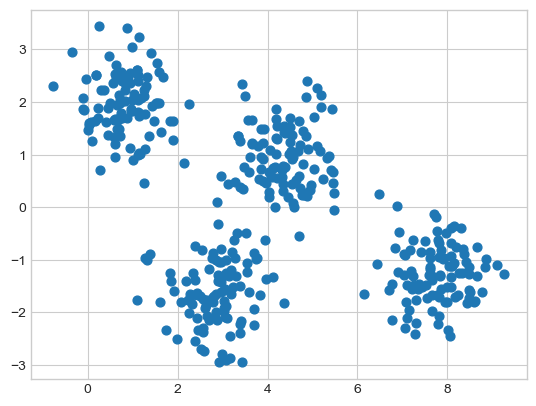

In [5]:
# Data generation
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std =0.60, random_state=0)
X = X[:, ::-1]

#Data visualization
plt.scatter(X[:,0], X[:, 1], s=40, cmap='viridis')

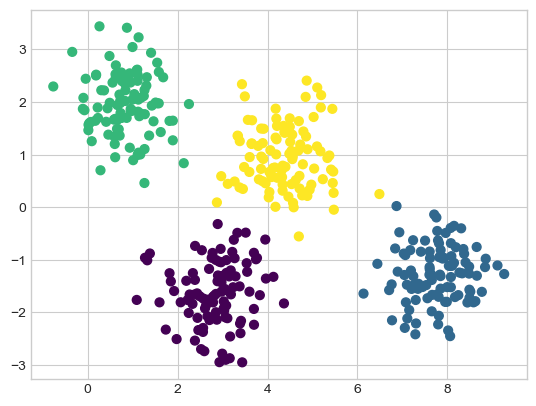

In [7]:
# GMM using for the clustering
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)

#Data visualization
plt.scatter(X[:,0], X[:, 1], c=labels, s=40, cmap='viridis')


In [9]:
# Determining the probability of points belonging to specific clusters.
probs = gmm.predict_proba(X)
# Probability of belonging to one of the 4 clusters for the first 10 points.
print(probs[:10].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.014 0.    0.    0.986]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]]


In [11]:
## Estimation-Maximization Algorithm for GMM
# Step E - for each point, find weights encoding the probability of belonging to the cluster
# Step M - update the location, normalization, and shape of the cluster based on all data points, using the weights from step E

'''code from the book Python Data Science Handbook - Jake VanderPlas'''
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ## drawing an ellipse with a specific position and covariance
    ax = ax or plt.gca()

    # change of covariance to principal axes
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # draw ellipse
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:,0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:,0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

# The GMM algorithm include:
# - the mean vector (μ),
# - the covariance matrix (Σ),
# - the weight (π).

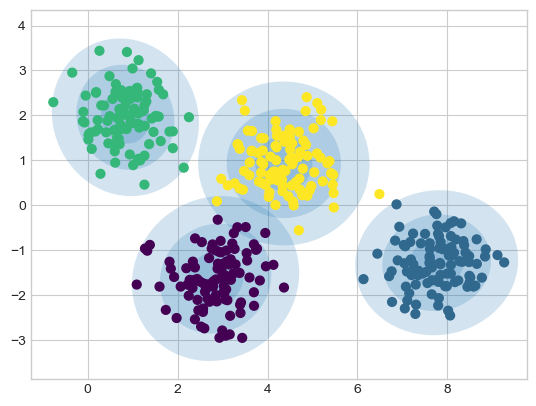

In [13]:
# Drawing ellipses for clusters by applying and visualizing the GMM algorithm 
# on the above data for 4 clusters, without training, and based on the above function.
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

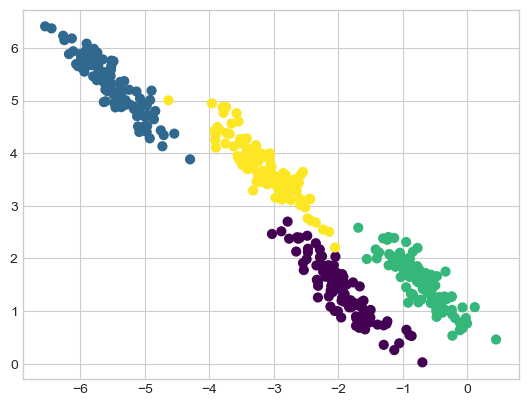

In [15]:
## Adjusting GMM to a more “stretched” data set.

# Linear transformation of data in a two-dimensional space. I create more elongated data by multiplying it by a 2x2 matrix
# Transforming data into a more elongated form. Unlike the K-Means algorithm, 
# the GMM algorithm copes very well with this type of elongated or elliptical data clusters.
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2,2))

# Visualization of stretched data
plt.scatter(X_stretched[:,0], X_stretched[:, 1], c=labels, s=40, cmap='viridis')

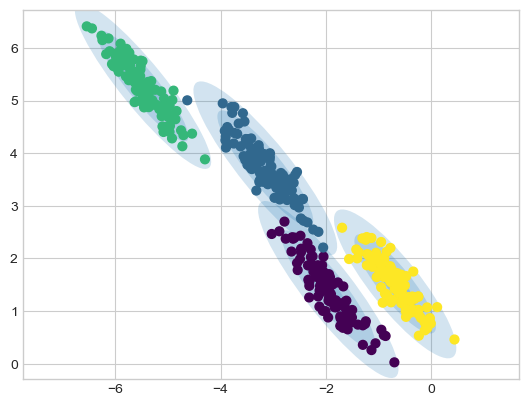

In [17]:
## Using a more complex and computationally complex “FULL” covariance 
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

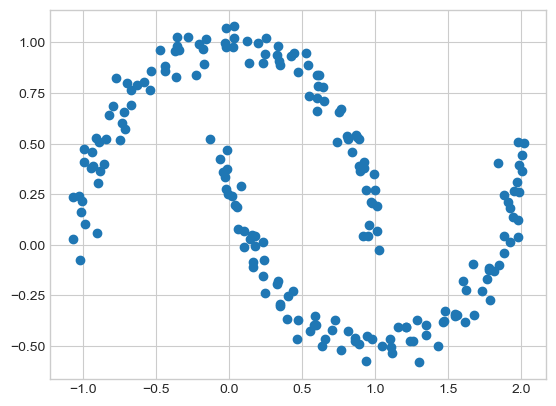

In [19]:
### GMM as a tool for estimating density

# generation and visualization of nonlinear data 
from sklearn.datasets import make_moons

X_moon, y_moon = make_moons(200, noise=.05, random_state=0)
plt.scatter(X_moon[:,0], X_moon[:,1])

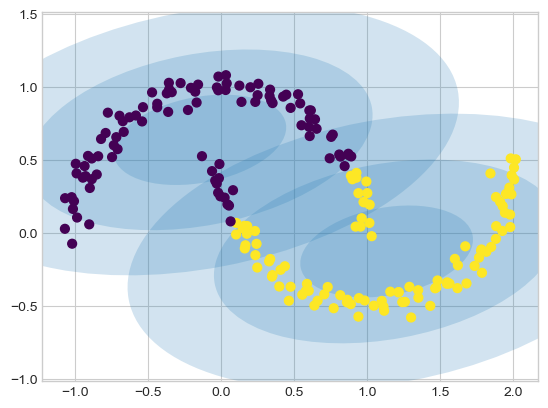

In [21]:
## fitting the above data to the GMM algorithm as a clustering model, using:
# a) 2 probabilistic components (16 Gaussian distributions will be modeled)
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, X_moon)

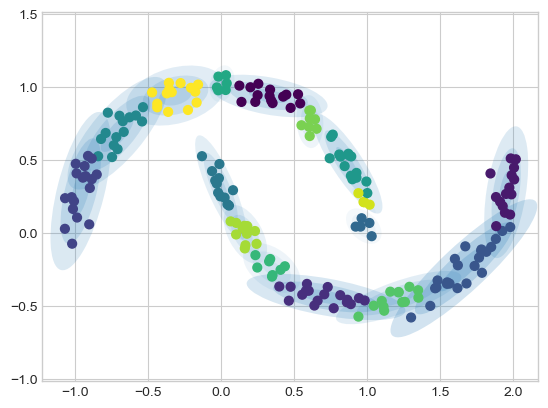

In [23]:
# b) 16 probabilistic components (16 Gaussian distributions will be modeled)
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, X_moon)

In [25]:
# The above data indicate that GMM is suitable for modeling the general distribution.
# GMM allows us to create a generative model, i.e., it allows us to randomly generate new data 
# for which the distribution will be similar to the input data.

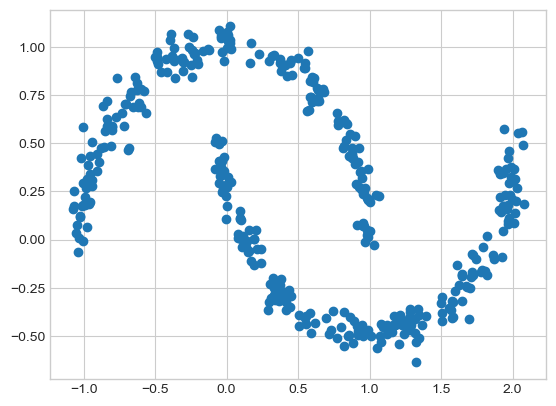

In [27]:
# I will generate and vizuale 400 new points from the above 16-component GMM model that match the original data distribution from the make_moons dataset.
X_new, y_new = gmm16.sample(400)
plt.scatter(X_new[:, 0], X_new[:, 1])

Text(0.5, 0, 'Number of components in Gaussian mixture distributions')

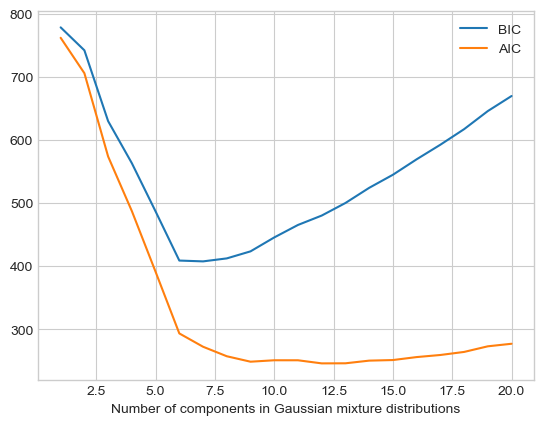

In [29]:
## Choosing the optimal number of components.
# To correct for overfitting, you can evaluate the log-likelihood of the data relative to the model.
# Another way to correct for overfitting is to adjust the likelihood of the model using an analytical criterion, such as:
# - Akaike information criterion
# - Schwarz Bayesian information criterion

# Using the GaussianMixture estimator to determine the graph for both criteria (AIC and BIC)
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full',
                          random_state=0).fit(X_moon)
          for n in n_components]

plt.plot(n_components, [m.bic(X_moon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_moon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('Number of components in Gaussian mixture distributions')

In [31]:
## Visualization of changes in Akaike and Bayesian information criteria values shows 
## that the optimal number of components is determined by the minimum.

# The 16 components selected for training are a bit too many. 
# A better choice would be 8-9 components (for AIC) or even fewer, 6 components (for BIC).